<a href="https://colab.research.google.com/github/Leo-Vincenzi/PUC-MVP_2/blob/main/MVP2_Machine_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_PUC_Logo.jpg" width="950"/>

# MVP Sprint 2: Machine Learning & Analytics
---
## Professora: Tatiana Escovedo
## Aluno: Leonardo Braga De Vincenzi
### Título: Modelos de *Machine Learning* para detecção de fraudes de cartão de crédito
##### (Abril/2024)
---

Nessa seção inicial configuraremos o MVP para não exibir mensagens de aviso.

In [ ]:
# Configurando para não exibir os warnings no meio da execução do MVP
#
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Por causa do tamanho excessivo do dataset estudado (> que 25Mbytes),
# não foi possível carregá-lo para o GitHub.
# Para tal, usamos o artifício abaixo para importar
# o arquivo "creditcart.csv" diretamente do KAGGLE DATA SOURCES,
# e depois fazer a descompressão, importação e armazenamento local
# no Notebook Colab

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T234331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daeaa310830c64e205969dc58f5ac689e7fe989ae2270b2bd0bbe0c54aa8262485ec085a332b2cac84adbfb48845fcbdc69c4f3a017335e347e5d28e28d9f3d12e503980f50f14494edd483d6e51b11ca9410fb1a4042d42458fd0fb80d97d56645fcb37e595c48b525b97c12e0f9fbc70142caa39c4e3c6435e53680de72ec5ba50ee46136314d38aa5a5380a4c46535d8041d00529f85d46fd8f2d7e8666ed63a9f4856709884f50730631e91aef79f39247fb82552316f6c24850ecc0939b481be592c7aa53713dc382d1efd4c6e665f112289d57b17ff8668e5926775c0bd72cdfc3e925c77f2320698bbbcfbce5bf6ec03269f1816fe5f28678e7f48bbe7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'rodando'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Baixando{directory}, {total_length} bytes comprimidos')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes baixados")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nBaixado e descomprimido.')
    except HTTPError as e:
        print(f'Falha para carregar (provavelmente expirou) {download_url} no path {destination_path}')
        continue
    except OSError as e:
        print(f'Falha para carregar {download_url} no path {destination_path}')
        continue

print('Importação do Dataset completa.')


Baixando, 69155672 bytes comprimidos
[==================================================] 69155672 bytes baixados
Baixado e descomprimido.
Importação do Dataset completa.


## 1.0 Definição do Problema
---
**Relevância**

A fraude em cartões de crédito é um problema global que causa enorme prejuízo. De acordo com o relatório *Card Fraud Losses Worldwide*, publicação comercial que cobre a indústria global de cartões de pagamento, perdas causadas por fraudes em cartões de crédito em todo o mundo chegarão a marca de **49** bilhões de dólares até **2030**. No Brasil, duas em cada dez pessoas já tiveram seus cartões de crédito fraudados.

Nesse viés, o advento do *Big Data* e a evolução de modelos mais robustos de *Machine Learning* permitiu o desenvolvimento de ferramentas que passaram a detectar e prevenir essas fraudes de maneira mais ágil e eficaz.

**Qual o objetivo desse MVP?**

O objetivo desse MVP é testar academicamente modelos de *Machine Learning* para alcançar a detecção de fraudes de cartão de crédito. Lembrando que o foco não é descobrir o melhor resultado, mas mostrar por meio do MVP o domínio e o conhecimento do assunto abordado.

**Como fazer isso?**

Inicialmente trataremos os dados, verificando por meio de estatísticas descritivas, a existência de dados ausentes e dados desequilibrados.

Depois exploraremos os dados, verificando as transações por tempo, seus valores e suas correlações.

Em seguida usaremos os modelos preditivos usando os métodos *ensemble* mais populares (algoritmos que utilizam vários modelos matemáticos que buscam obter um modelo final com melhores resultados), tais como *voting, bagging e boosting*.

**Sobre o *dataset* utilizado**

O *dataset* utilizado neste projeto contêm transações de cartões de crédito, efetuadas por clientes europeus, obtidas no mês setembro de 2013. Este conjunto de dados apresenta transações ocorridas durante dois dias, onde foram verificadas **492** fraudes em um total de em **284.807** transações financeiras. Trata-se de um conjunto de dados altamente desequilibrado, já que a classe positiva (de fraudes) representa apenas **0,17%** do total das transações abordadas.

Ele contém apenas dados de entrada numéricos, que são o resultado de uma transformação PCA (*Principal Component Analysis*). Esta foi empregada por ser considerada uma transformação linear ótima, sendo dessa forma muito utilizada para o reconhecimento de padrões.

**Dicionário de atributos**

* **Time** - Tempo transcorrido desde o início da coleta de dados;
* **Amount** - Valores das transações;
* **Class** - Valor-alvo que define se uma transação foi fraudulenta ou não: Normal = 0 e Fraude = 1;
* **(V1, V2, V3, ... V28)** - Valores que caracterizam as transações, e obtidos a partir da transformação PCA, técnica essa de redução de dimensionalidade que visa preservar a confidencialidade de dados dos clientes.

**Restrições do dataset**

Todo projeto que testa modelos preditivos de *Machine Learning* necessita de um *dataset* suficientemente robusto para que o resultados obtidos sejam coerentes e válidos, permitindo que ocorra um treino correto para a validação dos seus modelos.

E a limitação do *GitHub* em receber arquivos maiores que 25MBytes restringe a obtenção desses resultados, aumentando a dificuldade de obter resultados palpáveis nesse tipo de projeto.

Devido a questões de confidencialidade, não foram fornecidas as todas características originais e/ou outras informações sensíveis sobre os dados dos clientes de cartão de crédito.

**Observações importantes**

* As características **V1, V2, V3, ... V28** são os principais componentes obtidos com PCA;
* Os únicos atributos que não foram transformados com PCA são "**Time**" e "**Amount**" e "**Class**";
* O atributo "**Time**" contém os segundos decorridos entre cada transação, e a primeira transação no conjunto de dados.
* O atributo "**Amount**" é o valor da transação, e pode ser usado para aprendizado sensível em relação ao custo, dependendo da observação.
* O atributo "**Class**" é a resposta da questão, e assume valor 1 (positivo) em caso de fraude e 0 (negativo) no caso contrário, ou seja, em uma transação normal.

## 2.0 Carga de Dados
---

Nessa seção iremos importar bibliotecas e parametrizar algumas variáveis de uso geral. E iremos usar a biblioteca *Pandas* (*Python Data Analysis Library*) para carregar de o arquivo .csv disponível online. O desafio foi carregar um arquivo de tamanho **143,8**MBytes no *GitHub*, que possui limitação de download de **25**MBytes.

In [ ]:
# Fazendo os imports das bibliotecas
#
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
!pip install catboost -q
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  # métrica usada para RandomForrestClassifier
NUM_ESTIMATORS = 100 # número de estimadores usados ​​para RandomForrestClassifier
NO_JOBS = 4 # número de jobs paralelos usados ​​para RandomForrestClassifier

# Percentual de divisão do dataframe em TRAIN/VALIDATION/TEST
VALID_SIZE = 0.20 # validação simples usando train_test_split
TEST_SIZE = 0.20 # tamanho do teste usando_train_test_split

NUMBER_KFOLDS = 5 # número de KFolds para validação cruzada
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 # número de iterações
EARLY_STOP = 50 # paradas antecipadas
OPT_ROUNDS = 1000  # será ajustado posteriormente com base nas melhores rodadas
VERBOSE_EVAL = 50 # mostra resultado da métrica

IS_LOCAL = False
import os

if(IS_LOCAL):
    PATH="../input/credit-card-fraud-detection"
else:
    PATH="../input"
print(os.listdir(PATH))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.1 MB/s eta 0:00:00
['creditcard.csv']


Guardaremos em **Dataset** o dataframe das movimentações de cartões de crédito. Por causa do grande tamanho do seu arquivo original ".csv" (> que 25 Mbytes), não foi possível baixá-lo pelo GitHub.

In [ ]:
dataset = pd.read_csv(PATH+"/creditcard.csv")

Verificaremos também a versão da **Matplotlib** instalada.

In [ ]:
# Verificando a versão da matplotlib instalada
#
print(f"A versão MatPlotLib instalada é a {mpl.__version__}")

A versão MatPlotLib instalada é a 3.7.1


## 3.0 Análise dos Dados
---
Preliminarmente verificaremos informações básicas do nosso *dataset*.

In [ ]:
print("Tamanho do Dataset: A tabela de dados Credit-Card-Fraud-Detection contém",dataset.shape[0],"linhas e", dataset.shape[1], "colunas")

Tamanho do Dataset: A tabela de dados Credit-Card-Fraud-Detection contém 284807 linhas e 31 colunas


Verificamos que nosso objeto de estudo é um robusto *dataset*, sucificente para o objetivo desse MVP.

Checaremos a identificação dos nomes dos atributos de coluna no *dataset*.

In [ ]:
# Mostrando o nome dos atributos do dataset
#
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

A primeira linha do arquivo contém o nome dos atributos.

### 3.1. Observação dos Dados

Observaremos como estão organizados os dados e como eles se relacionam, categorizaremos algumas colunas, faremos algumas perguntas para melhor entendê-lo e tiraremos algumas conclusões acerca de seu conjunto.

Começamos examinando as primeiras e as últimas 5 linhas do *dataset*.

In [ ]:
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Observamos por essa amostra do *dabaset* que o atributo "**Time**" apresenta transações ocorrendo tanto em momentos distintos como simultâneos.

Também verificamos que o atributo "**Class**" foi caracterizado pelos valores 0 e 1.

Por fim verificamos que o atributo "**Amount**" possui diversos e diferentes valores realizados pelas transações financeiras feitas pelo cartão de crédito.

Vejamos mais detalhes dos dados que estamos trabalhando.

In [ ]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Olhando para o atributo **Time**, verificamos que o dataset contêm **284.807** transações obtidas durante **2** dias consecutivos.

A primeira transação se inicia em 0 segundos e a última em 172.792 segundos (lembrando que 2 dias possuem 172.800 segundos). As transações distribuem-se por entre esses 2 dias, algumas ocorrendo simultaneamente, outras espaçadas por alguns segundos.


Verificaremos abaixo o número de valores únicos de cada atributo.

In [ ]:
# Verificando o número de valores únicos dos atributos
#
dataset.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

A única informação relevante obtida pela análise dos valores únicos do nosso dataset é que, de um total de **284.807** transações de cartão de crédito, **124.592** ocorreram em momentos cronológicos únicos.

Verificaremos agora qual o valor mais frequente para cada atributo do conjunto de dados do dataset.

In [ ]:
# Calculando o valor da moda (valor mais frequente) para cada um dos atributos do dataset
#
moda = dataset.mode()
moda[:1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,163152.0,1.245674,-0.326668,-2.752041,-0.842316,-0.562777,-1.011073,-0.432126,-0.160211,0.170362,-0.075186,-0.356749,-0.07346,-0.51776,0.406969,1.124147,-0.371962,-0.601957,-0.438992,-0.33059,-0.18037,-0.262581,-0.816264,0.020675,0.357827,0.186423,-0.398828,-0.035866,-0.060282,1.0,0.0


Como as transações marcadas em segundos pelo atributo "**Time**" ocorreram de forma distribuida durante 2 dias, o atributo "**Class**" possui apenas 2 valores (0 e 1), o atributo "**Amount**" representa o valor gasto na transação e os atributos "**V1 a V28**" passaram por uma transformação linear, a obtenção do valor mais frequente (moda) do conjunto de dados dos atributos não acrescenta muito em nossa análise.

### 3.2. Verificação dos Dados Ausentes

Vamos verificar se há algum dado faltando.

In [ ]:
total = dataset.isnull().sum().sort_values(ascending = False)
percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percentual']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Concluímos que não há dados faltantes em todo o conjunto do nosso *dataset*.

### 3.3. Verificação do Desequilíbrio dos Dados

Vamos verificar o desequilíbrio dos dados em relação ao atributo **"Class"**.


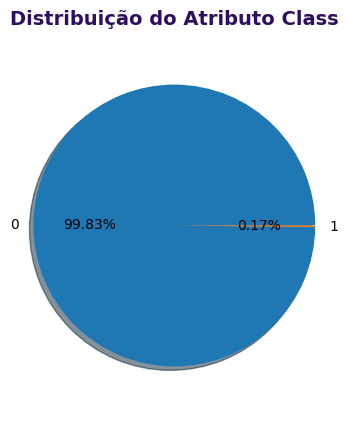

In [ ]:
# Plotando um gráfico pizza mostrando a distribuição do atributo "Class"
#
counts = dataset['Class'].value_counts()
labels = counts.index
#rotulos = counts.index
explode = (0, 0)

# Definindo as linhas gerais do gráfico
#
plt.figure(figsize = (4, 5))
plt.pie(x=counts, labels=labels, explode=explode, autopct = '%1.2f%%', startangle=0, shadow=True)
plt.title('Distribuição do Atributo Class', weight = 'bold', color = '#2F0F5D', fontsize = 14)
plt.axis('equal')
plt.show()

Apenas **0,17%** (**492** ocorrências) das transações foram fraudulentas. Isso significa que temos dados são altamente desequilibrados em relação ao atributo **Class**.

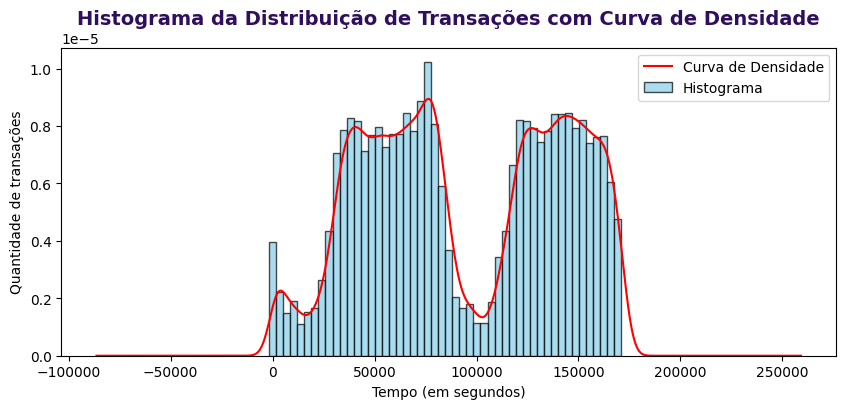

In [ ]:
# Plotando um histograma de distribuição de transações com curva de densidade sobreposta
#
fig, ax = plt.subplots(figsize = (10, 4))
ax.hist(dataset['Time'], bins = 50, edgecolor = 'black', alpha = 0.7, color = 'skyblue', align = 'left', density = True)
dataset['Time'].plot(kind = 'kde', color = 'red', ax = ax)

# Definindo as linhas gerais do gráfico
#
ax.set_xlabel('Tempo (em segundos)')
ax.set_ylabel('Quantidade de transações')
ax.set_title('Histograma da Distribuição de Transações com Curva de Densidade', weight = "bold", color = "#2F0F5D", fontsize = 14)
ax.legend(['Curva de Densidade', 'Histograma'])
plt.show()

Percebemos que as transações com cartões de crédito ocorrem de forma cíclica durante 48h, havendo maior número durante o dia, e diminuindo o número de transações à noite, o que faz todo sentido.

## 4.0 Exploração dos Dados
---

### 4.1. Transações por Tempo

In [ ]:
class_0 = dataset.loc[dataset['Class'] == 0]["Time"]
class_1 = dataset.loc[dataset['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
plot(fig)

'temp-plot.html'

As transações fraudulentas têm uma distribuição mais uniforme do que as transações válidas, já que são distribuídas igualmente no tempo, o que demonstra que os fraudadores agem até mesmo durante a noite, mostrando não haver um comportamento cronológico quando ocorre uma fraude.

Vejamos mais detalhes da distribuição de tempo de ambas as classes de transação (normal e fraudulenta), bem como dos valores agregados de contagem e quantidade de transações, por hora. Assumiremos, com base na observação da distribuição temporal das transações, o segundo como unidade de tempo.

In [ ]:
dataset['Hour'] = dataset['Time'].apply(lambda x: np.floor(x / 3600))

tmp = dataset.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


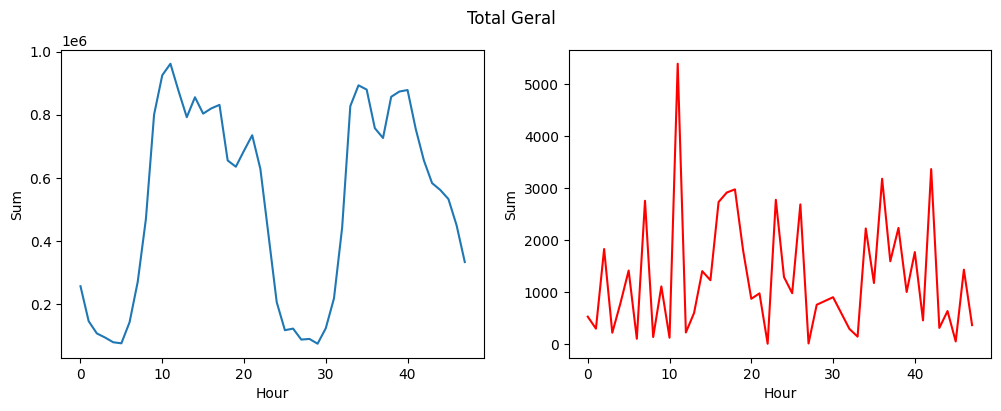

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Geral")
plt.show();

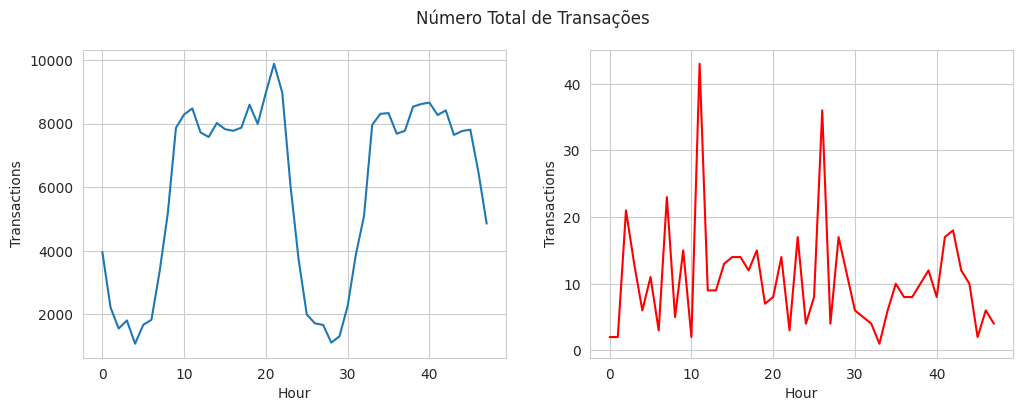

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Número Total de Transações")
plt.show();

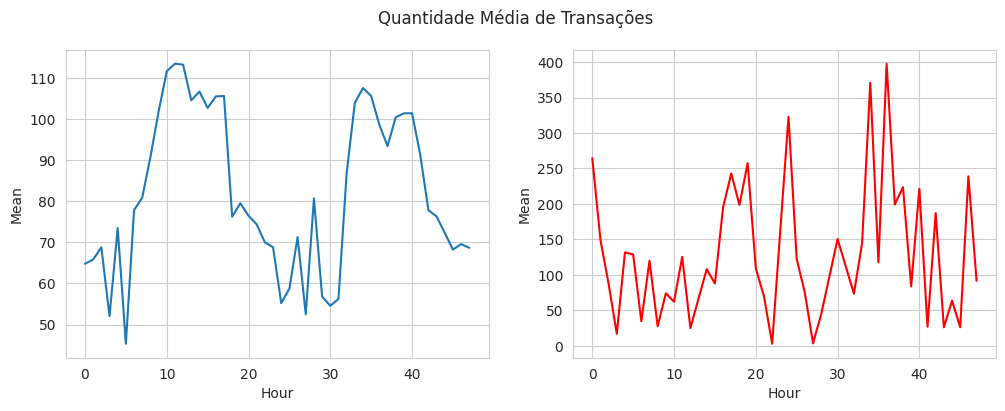

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Quantidade Média de Transações")
plt.show();

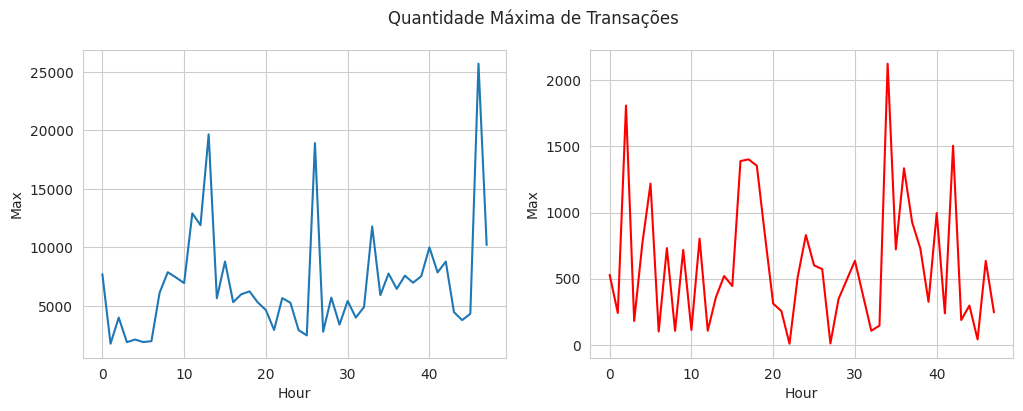

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Quantidade Máxima de Transações")
plt.show();

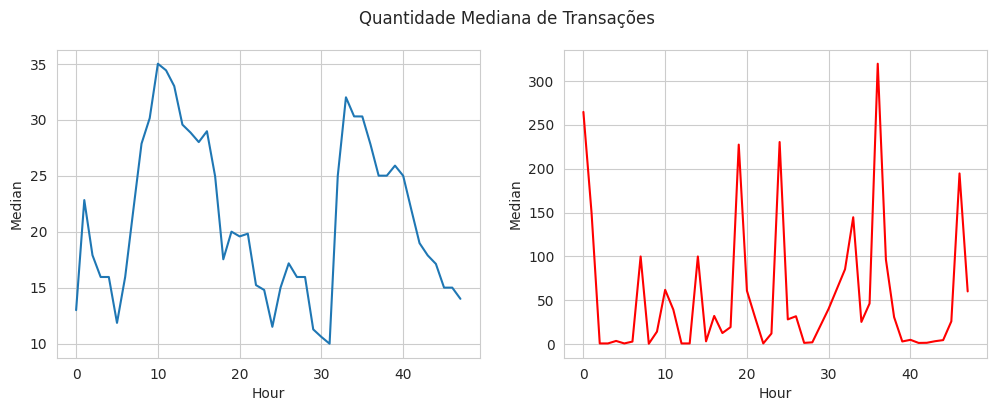

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Quantidade Mediana de Transações")
plt.show();

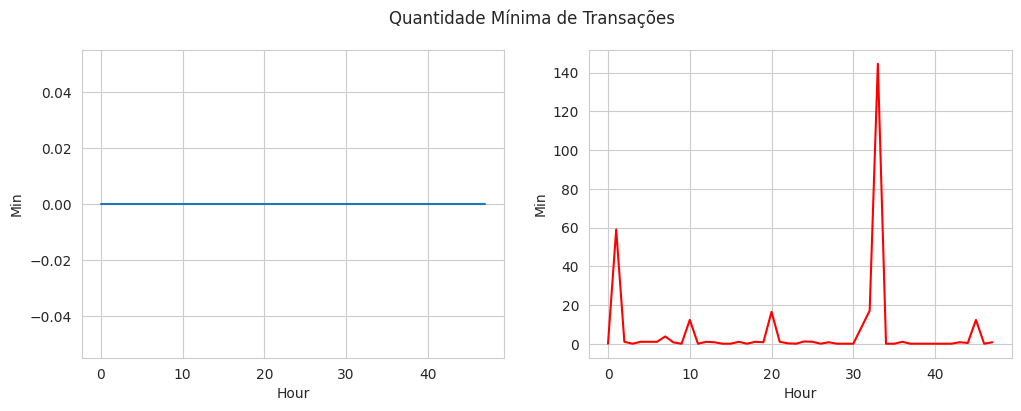

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Quantidade Mínima de Transações")
plt.show();

### 4.2. Valor das Transações

Analisaremos o valor das transações por meio de *boxplot* (ou caixa de bigodes), gráfico que mostra a forma, a tendência central e a variabilidade dos dados. Esse gráfico foi escolhido porque é capaz de exibir a distribuição de dados com base em um resumo de cinco valores: mínimo, primeiro quartil, mediana, terceiro quartil e máximo.

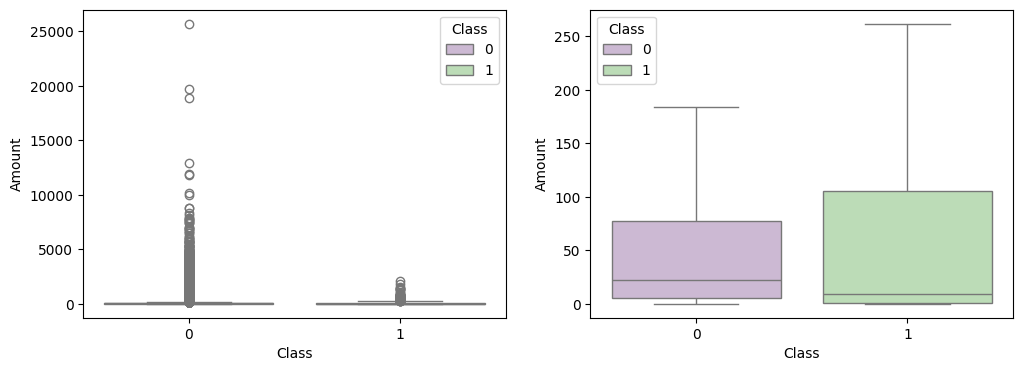

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=dataset, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=dataset, palette="PRGn",showfliers=False)
plt.show();

Veremos a seguir a descrição estatística da classe 0 (transação normal, ou seja, sem fraude).

In [ ]:
tmp = dataset[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe() # descrição estatística da classe 0 (normal, não fraude)

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Agora exibimos a descrição estatística da classe 1 (transação fraudulenta).

In [ ]:
class_1.describe() # descrição estatística da classe 1 (fraude)

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Podemos concluir que a transação normal tem valor médio maior, Q1 maior, Q3 e Q4 menores e outliers maiores; transações fraudulentas têm um Q1 e média menores, um Q4 maior e valores discrepantes menores.

Vamos representar graficamente as transações fraudulentas (**Amount**) em relação ao tempo. O tempo mostrado é em segundos, a partir do início do período (total de 48h, ou seja, durante 2 dias).

In [ ]:
fraud = dataset.loc[dataset['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Quantidade de transações fraudulentas',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
plot(fig)

'temp-plot.html'

### 4.3. Correlação de Recursos

O coeficiente de correlação de Pearson pode ter um intervalo de valores de +1 a -1. Um valor de 0 indica que não há associação entre as duas variáveis. Um valor maior que 0 indica uma associação positiva. Isto é, à medida que o valor de uma variável aumenta, o mesmo acontece com o valor da outra variável.

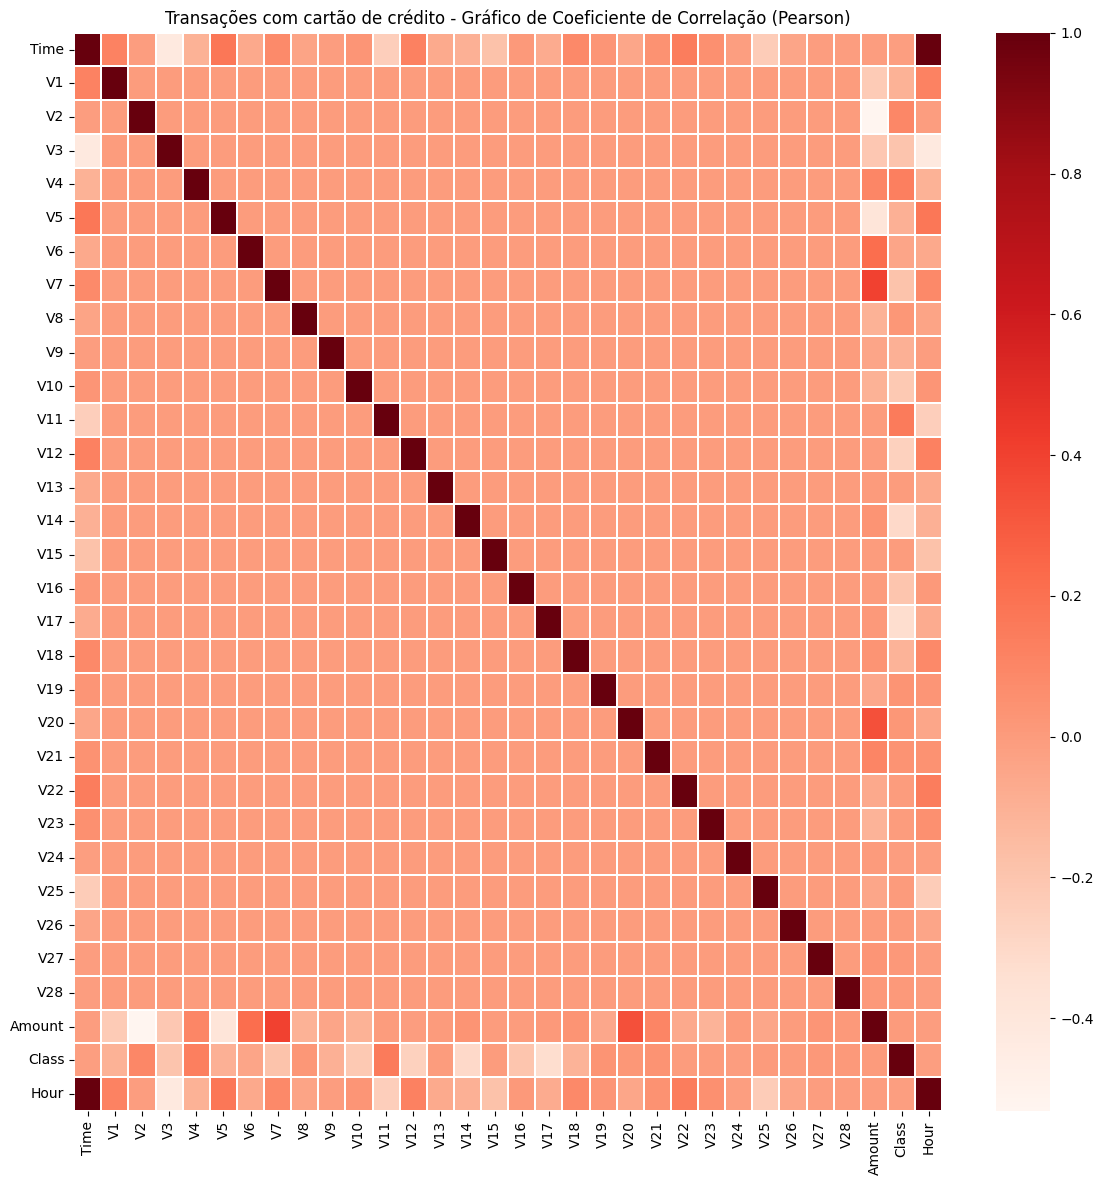

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Transações com cartão de crédito - Gráfico de Coeficiente de Correlação (Pearson)')
corr = dataset.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

Como esperado, não há correlação notável entre os recursos **V1** a **V28**.

Verificamos que há certas correlações entre alguns desses recursos e o atributo **Time** (correlação inversa com **V3**) e o atributo **Amount** (correlação direta com **V7** e **V20**, correlação inversa com os atributos **V1** e **V5**).

Vamos traçar os valores correlacionados e inversamente correlacionados no mesmo gráfico. Iremos começar com os valores diretamente correlacionados: {V20; Amount} e {V7; Amount}.

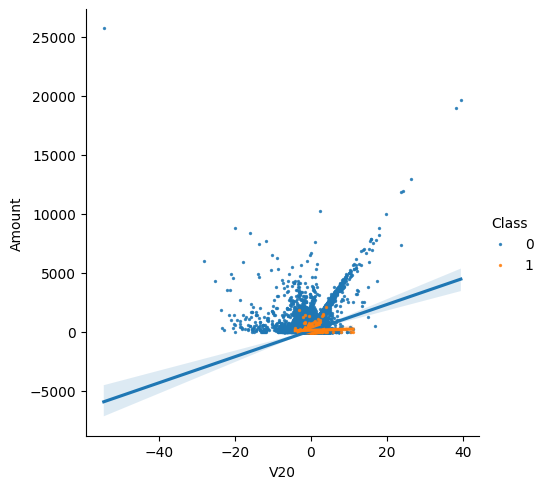

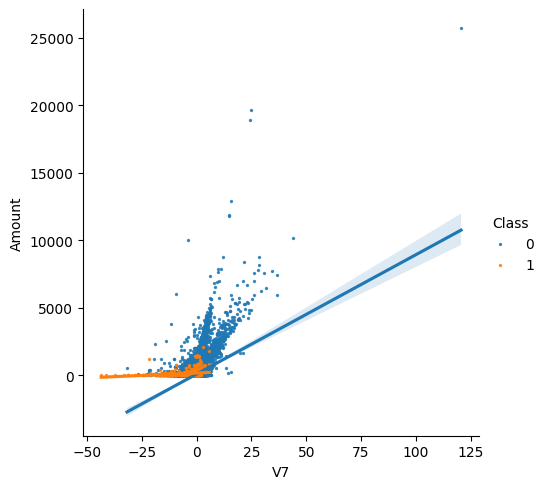

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Podemos confirmar que os dois pares de características estão correlacionados (as linhas de regressão para **Class = 0** têm uma inclinação positiva, enquanto a linha de regressão para **Class = 1** tem uma inclinação positiva menor).

Vamos traçar agora os valores correlacionados inversamente.

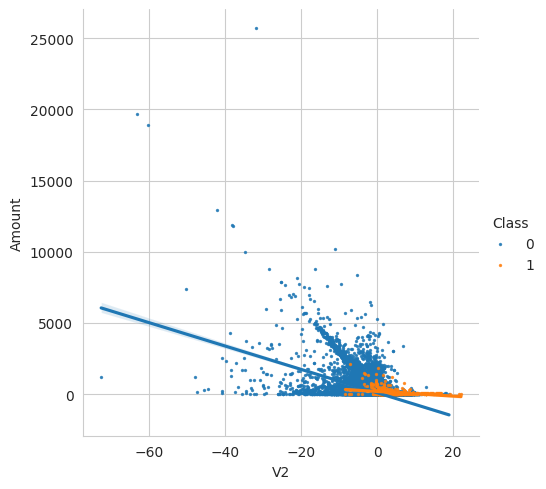

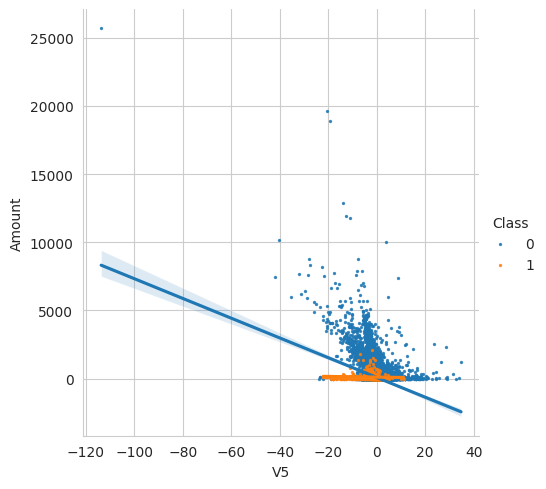

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=dataset, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

Podemos confirmar que os dois pares de características são inversamente correlacionados (as linhas de regressão para **Class = 0** têm uma inclinação negativa, enquanto as linhas de regressão para **Class = 1** têm uma inclinação negativa pequena).


### 4.4. Gráfico de Densidade de Recursos (*Feature Density*)

O gráfico de densidade possui a mesma função do histograma, mas representa a distribuição como uma curva contínua. A altura da curva no eixo vertical representa uma estimativa da probabilidade de um elemento possuir aquele valor.

<Figure size 640x480 with 0 Axes>

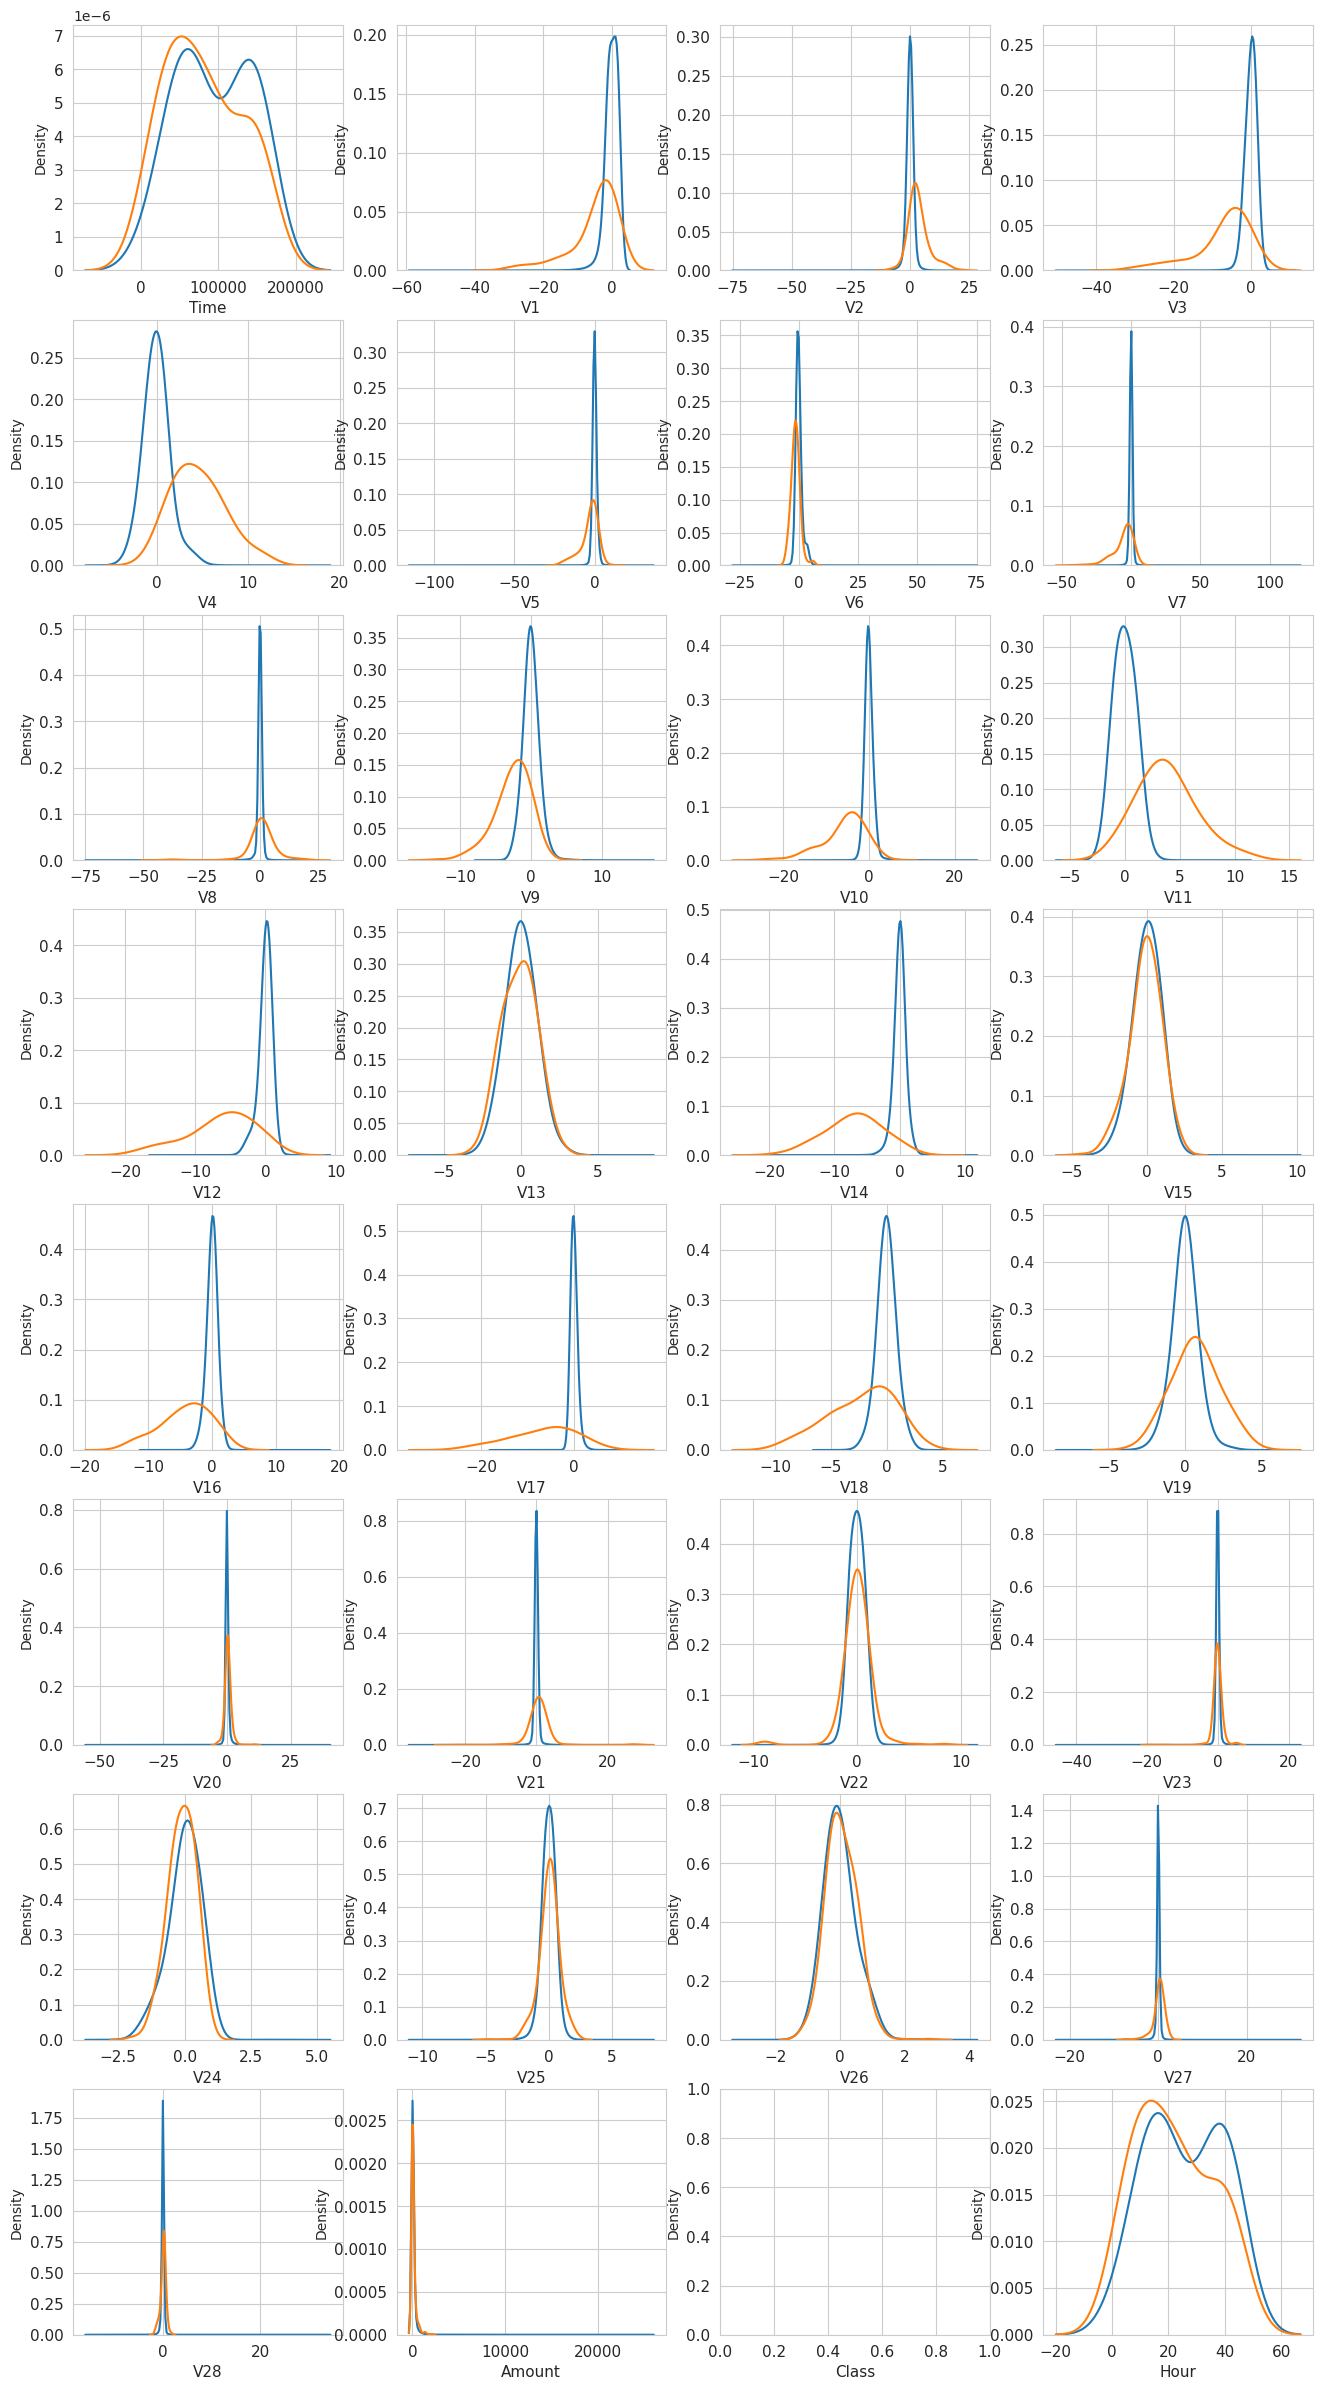

In [ ]:
var = dataset.columns.values

i = 0
t0 = dataset.loc[dataset['Class'] == 0]
t1 = dataset.loc[dataset['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,30))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=11)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=11)
plt.show();

Para algumas das características podemos observar uma boa seletividade em termos de distribuição para os dois valores de **Class**: **V4**, **V11** possuem distribuições claramente separadas para os valores de **Class** **0 e 1**, **V12**, **V14**, **V18** estão parcialmente separados, **V1**, **V2**, **V3** , **V10** possuem um perfil bastante distinto, enquanto **V25**, **V26**, **V28** possuem perfis semelhantes para os dois valores de **Class**.

Em geral, com poucas exceções (**Time** and **Amount**), a distribuição de características para transações legítimas (valores de **Class = 0**) é centrada em torno de 0, às vezes com uma longa fila em uma das extremidades. Ao mesmo tempo, as transações fraudulentas (valores de **Class = 1**) apresentam uma distribuição assimétrica.

## 5.0 Preparação de Dados
---

Iremos agora definir os atributos preditores (**Predictors**) e a variável alvo (**Target**). Características categóricas, se houvesem, também poderiam ser definidas nesse ponto. Mas, no caso do nosso *dataset*, não há necessidade de recurso categórico.

In [33]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Nesse ponto vamos definir os subconjuntos de dados de treinamento (**Tran_df**), validação (**Valid_df**) e teste (**Test_df**), com o tamanho dos subconjuntos parametrizados anteriormente.

In [34]:
train_df, test_df = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## 6.0 Modelagem e Treinamento
---
Um modelo preditivo em *Machine Learning*  é - de forma simplificada - uma função matemática que pode ser aplicada a um *Big Data*. O objetivo desse tipo de modelo é evidenciar padrões capazes de apontar as tendências.

Ele se baseia em algoritmos estatísticos e técnicas de ML para calcular probabilidades de resultados, a partir de dados armazenados que ocorreram em um determinado histórico de atividades.

Em um ambiente de negócio cada vez mais competitivo e dinâmico, modelos preditivos vêm crescendo e se tornando cada vez mais populares, ao se mostrarem capazes de previnir riscos e alavancar vendas e lucros.

A técnica de ML que combina o resultado de múltiplos modelos em busca de produzir um melhor modelo preditivo é chamada de método *ensemble*. O métodos *ensemble* mais populares são *voting, bagging e boosting*.

Decidimos nesse MVP testar alguns desses métodos populares em nosso *dataset*. Vamos começar pelo método *ensemble* do tipo *bagging*.

### 6.1. Random Forest


*Ensembles* do tipo *bagging*, são construídos vários modelos a partir de diferentes subamostras do conjunto de dados de treinamento.

Um exemplo muito conhecido dos *ensembles* do tipo *bagging* é o algoritmo *Random Forest* (ou Floresta Aleatória), que representa uma melhoria em relação ao bagging tradicional com árvores de decisão.

Para tal, iremos usar o **RandomForestClassifier**. Inicialmente definiremos os parâmetros do modelo, e então treinar o modelo usando o conjunto de treinamento. Depois, então, usaremos o conjunto de validação para realizar a validação.

Utilizaremos como critério de validação **GINI**, cuja fórmula é **GINI = 2 * (AUC) - 1**, onde **AUC** é a **Característica Operacional do Receptor - Área Sob Curva (ROC-AUC)**. O número de estimadores é definido como **100** e o número de trabalhos paralelos é definido como **4**.

Começamos inicializando o *RandomForestClassifier*.

In [35]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Vamos treinar o **RandonForestClassifier** usando os dados **Train_df** e a função **Fit** (demora um pouco...).

In [36]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Vamos agora prever os valores para os dados **Valid_df**, usando a função **Predict**.

In [37]:
preds = clf.predict(valid_df[predictors])

Vamos também visualizar a importância dos atributos.


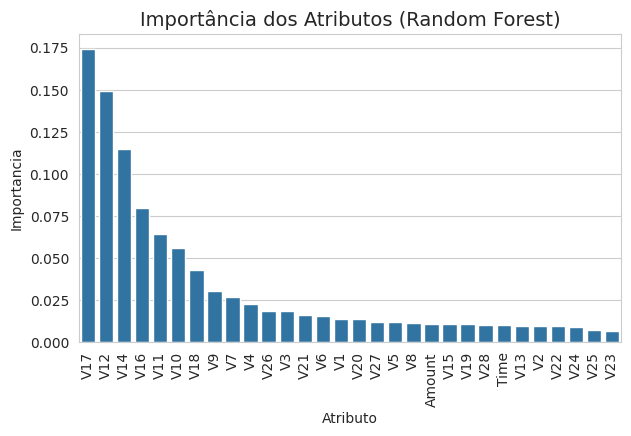

In [41]:
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Random Forest)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Descobrimos que as características mais importantes são para os atributos **V17**, **V12**, **V14**, **V16**, **V11** e **V10**.


#### 6.1.1 Matriz de Confusão

Iremos mostrar uma matriz de confusão para os resultados que obtivemos.

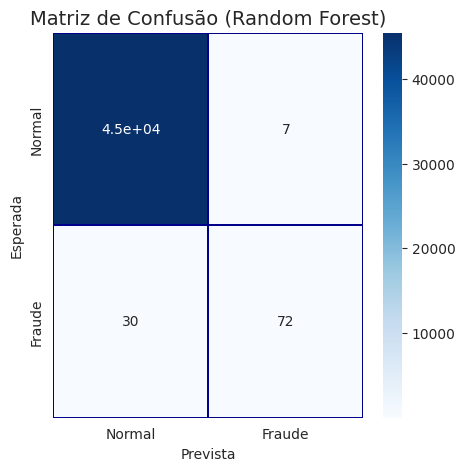

In [42]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Random Forest)', fontsize=14)
plt.show()

#### 6.1.2 Erro Tipo I e II

Confirmamos acima que a matriz de confusão não é a melhor ferramenta para representar os resultados no nosso caso, em que os dados de fraude e não fraude são desequilibrados.

Na verdade precisaremos de uma métrica diferente que leve em conta ao mesmo tempo tanto a seletividade como a especificidade do método que estamos usando, de modo a minimizar ao mesmo tempo tanto os erros *Tipo I* como os do *Tipo II*.

Lembrando que, quando você rejeita algo que é verdadeiro, você está cometendo um erro do *Tipo I*. E quando não está rejeitando algo falso, você está cometendo um erro do *Tipo II*.

**Hipótese Nula** (**H0**) - A transação não é uma fraude.

**Hipótese Alternativa** (**H1**) - A transação é uma fraude.

**Erro tipo I** - Você rejeita a hipótese nula quando a hipótese nula é realmente verdadeira.

**Erro tipo II** - Você não consegue rejeitar a hipótese nula quando a hipótese alternativa é verdadeira.

**Custo do erro Tipo I** - Você presume erroneamente que a transação é uma fraude e uma transação verdadeira é rejeitada.

**Custo do erro Tipo II** - Você presume erroneamente que a transação não é uma fraude e uma transação fraudulenta é aceita.

A seguir explicamos graficamente o que são erros *Tipo I* e *II*:

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_Tipo_1_2_a.jpg" width="600"/>


Esta imagem abaixo explica de forma didática as difereças entre *Tipo I e II*:

<img src="https://raw.githubusercontent.com/Leo-Vincenzi/PUC-MVP_2/main/MVP2_Tipo_1_2.jpg" width="600"/>

Vamos conhecer agora a área sobre a curva calculando **ROC-AUC**.

In [43]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

A pontuação **ROC-AUC** obtida com **RandomForrestClassifier** é **0.852**.



### 6.2 Ada Boost

Os *ensembles* do tipo *boosting* são algorítmos sequenciais. Eles criam uma sequência de modelos na qual um modelo tenta corrigir os erros do modelo anterior.

*AdaBoost* (Classificador de Boosting Adaptativo) foi o primeiro algoritmo de *boosting* bem-sucedido e é considerado o mais popular. Para testar esse modelo usaremos o *AdaBoostClassifier*.

Vamos definir os parâmetros desse modelo e inicializá-lo.

In [54]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

Ajuste do modelo (função "**Fit**")

In [55]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

Vamos agora prever os valores **Target** para os dados **Valid_df**, usando a função "**Predict**".

In [56]:
preds = clf.predict(valid_df[predictors])

Vamos ver também a importância dos atributos para *Ada Boost*.

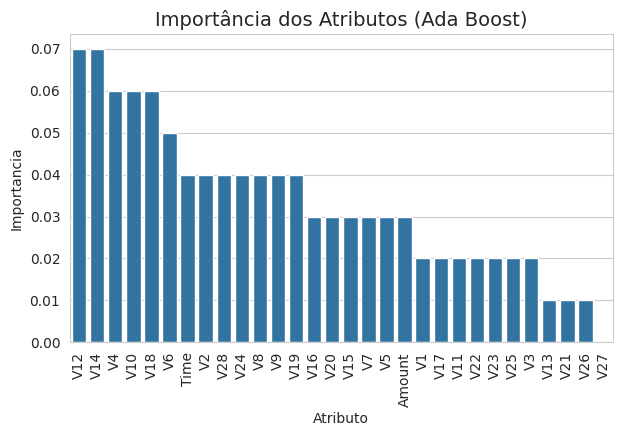

In [57]:
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Ada Boost)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Verificamos que os atributos mais importantes são **V12**, **V14**, **V4**, **V10**, **V18** e **V6**.

Vamos visualizar a matriz de confusão do Ada Boost.

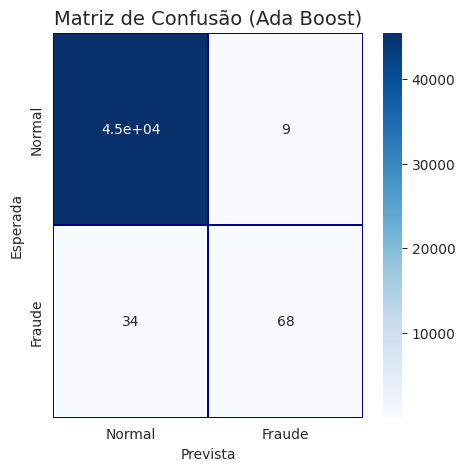

In [58]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Ada Boost)', fontsize=14)
plt.show()

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [59]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

A pontuação **ROC-AUC** obtida com *AdaBoostClassifier* é **0,833**.

### 6.3 Cat Boost

Cat Boost (*Category Boosting*) é um algoritmo de *boosting* para árvores de decisão com suporte para manipulação de dados categóricos. Uma das vantagens desse algoritmo é saber lidar muito bem com variáveis categóricas de um jeito mais intuitivo que outros algoritmos baseados árvores de decisão. Para tal usaremos o *CatBoostClassifier*.

Vamos definir os parâmetros do modelo e inicializá-lo.

In [60]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [61]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 602ms	remaining: 5m
50:	total: 57s	remaining: 8m 21s
100:	total: 1m 30s	remaining: 5m 56s
150:	total: 1m 59s	remaining: 4m 35s
200:	total: 2m 28s	remaining: 3m 41s
250:	total: 3m 3s	remaining: 3m 1s
300:	total: 3m 31s	remaining: 2m 19s
350:	total: 4m	remaining: 1m 42s
400:	total: 4m 29s	remaining: 1m 6s
450:	total: 5m	remaining: 32.7s
499:	total: 5m 28s	remaining: 0us


Vamos agora prever os valores **Target** para os dados **Valid_df**, usando a função "**Predict**".

In [63]:
preds = clf.predict(valid_df[predictors])

Vejamos também a importância dos atributos no *Cat Boost*.

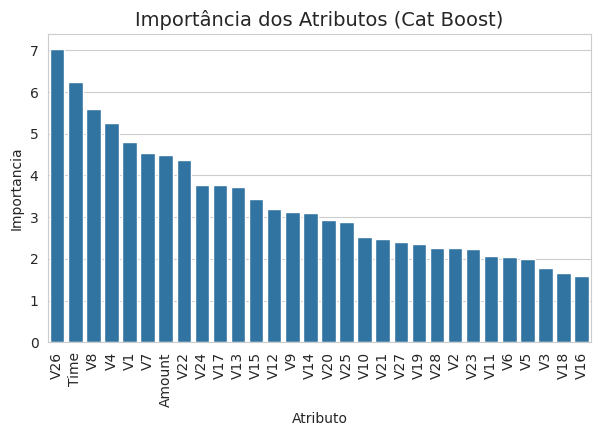

In [62]:
tmp = pd.DataFrame({'Atributo': predictors, 'Importancia': clf.feature_importances_})
tmp = tmp.sort_values(by='Importancia',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Importância dos Atributos (Cat Boost)',fontsize=14)
s = sns.barplot(x='Atributo',y='Importancia',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Verificamos que para o Cat Boost os atributos que mais se destacam são **V26**, **V8**, **V4**, **V1**, **V7** e **V22**.

Vamos visualizar a matriz de confusão.

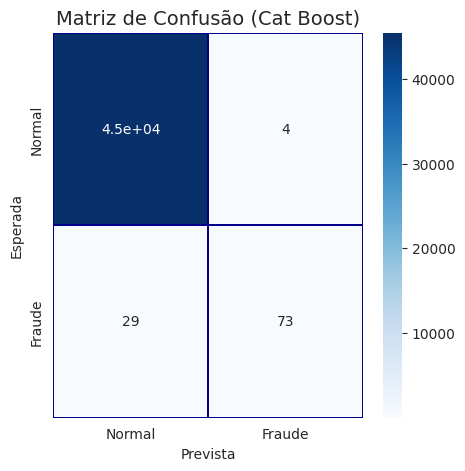

In [64]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Esperada'], colnames=['Prevista'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Matriz de Confusão (Cat Boost)', fontsize=14)
plt.show()

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [65]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

A pontuação ROC-AUC obtida com CatBoostClassifier após 500 iterações foi de **0,857**.

### 6.4 XG Boost

XG Boost é um algoritmo de *boosting* e significa *eXtreme Gradient Boosting*. A principal diferença é que o XG Boost usa uma técnica de regularização, sendo assim, a performance desse algoritmo é melhor e mais rápida. Para tal usaremos o *XGB*.


Inicializaremos a variável **DMatrix** para treinamento e validação, começando pelos conjuntos de dados. Também definiremos alguns dos parâmetros utilizados para o ajuste do modelo.

In [66]:
# Preparo do "train_df" e validação do dataset ("valid_df" e "test_df")
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# O que vamos monitorar (neste caso, "train" e "valid")
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Definição dos parâmetros XGBoost
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

Aqui treinamos o modelo.

In [67]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94043	valid-auc:0.89529
[100]	train-auc:0.97414	valid-auc:0.96283
[150]	train-auc:0.98510	valid-auc:0.98126
[200]	train-auc:0.99295	valid-auc:0.98520
[250]	train-auc:0.99519	valid-auc:0.98406
[262]	train-auc:0.99567	valid-auc:0.98377


A melhor pontuação de validação **ROC-AUC** foi **0,983**, para a rodada **262**.

Mostraremos agora a importância dos atributos.

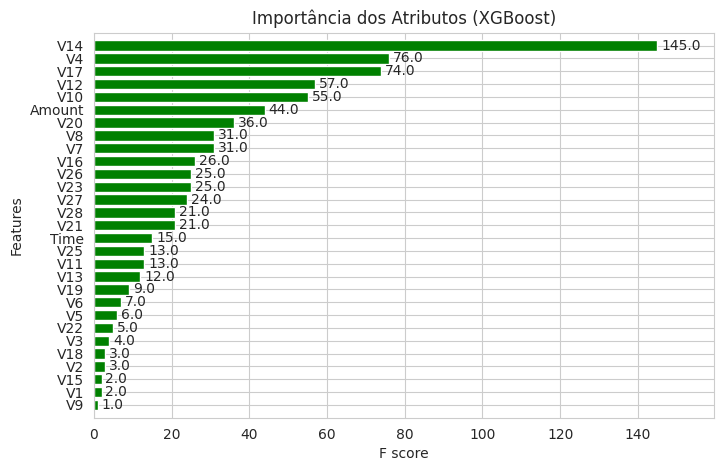

In [68]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Importância dos Atributos (XGBoost)", ax=ax, color="green")
plt.show()

Nesse caso usamos os conjuntos de dados de treinamento e validação. Usaremos o modelo treinado para prever o valor alvo do conjunto de teste.

In [69]:
preds = model.predict(dtest)

Vamos conhecer a área sobre a curva calculando **ROC-AUC**.

In [70]:
roc_auc_score(test_df[target].values, preds)

0.9796317400021104


A pontuação **ROC-AUC** para a previsão de dados recentes (conjunto de teste) é **0,979**.

### 6.5 Light GBM

Vamos continuar os testes com outro algoritmo de *boosting*, o *Light GBM*  (*Light Gradient-Boosting Machine*). *LightGBM* também lida bem com datasets categóricos e variáveis categóricas, usando o método *binning* ou *bucketing*. Começamos definindo os parâmetros do modelo. Usaremos esses parâmetros apenas para o primeiro modelo.

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # devemos deixá-lo ser menor que 2
          'max_depth': 4,  # "-1" significa sem limite
          'min_child_samples': 100,  # número mínimo de dados necessários numa folha
          'max_bin': 100,  # número de compartimentos agrupados para valores
          'subsample': 0.9,  # proporção de amostra da instância de treinamento
          'subsample_freq': 1,  # frequência da subamostra, <=0 significa sem ativação
          'colsample_bytree': 0.7,  # proporção de subamostragem de colunas ao construir cada árvore
          'min_child_weight': 0,  # Soma mínima do peso da instância necessária em uma folha
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split para regularização
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # porque os dados de treinamento são desequilibrados
         }

Vamos preparar o modelo, criando as estruturas de dados do dataset a partir dos conjuntos de treinamento e validação.

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

Vamos executar o modelo usando a função **Train**.

In [ ]:
evals_results = {}


model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
                  evals_result=evals_results,
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL,
                  feval=None)


TypeError: train() got an unexpected keyword argument 'evals_result'

A melhor pontuação de validação foi obtida para a rodada **85**, para a qual **ROC-AUC** foi aproximadamente **0,974**.

Vamos representar graficamente a importância da variável.

TypeError: booster must be Booster or LGBMModel.

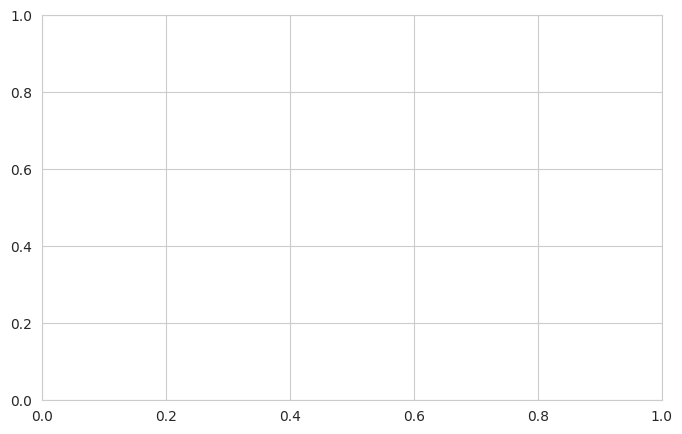

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Importância dos Atributos (LightGBM)", ax=ax,color="red")
plt.show()

Vamos prever agora o valor target dos dados de teste.

In [ ]:
preds = model.predict(test_df[predictors])

Vamos calcular a pontuação **ROC-AUC** para a previsão.

In [ ]:
roc_auc_score(test_df[target].values, preds)

A pontuação **ROC-AUC** obtida para o conjunto de teste é **0,946**.

Vamos usar agora a validação cruzada. Usaremos validação cruzada (KFolds) com 5 dobras. Os dados são divididos em 5 dobras e, por rotação, estamos treinando usando 4 dobras (n-1) e validando usando a 5ª (n-ésima) dobra.

O conjunto de testes é calculado como uma média das previsões.

In [ ]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Cria arrays e dataframes para armazenar resultados
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]

    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1

    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

A pontuação **ROC-AUC** para a previsão dos dados do teste foi de **0,930**. A previsão do teste foi feita a partir da média das previsões.

In [ ]:
pred = test_preds

## 7.0 Avaliação de Resultados
---

Iniciamos esse MVP investigando os dados do *dataset* obtido, verificando o seu desequilíbrio, visualizando seus recursos e entendendo o relacionamento entre os diferentes atributos.

Em seguida, observamos modelos preditivos. Nosso *dataset* foi dividido em 3 partes, um conjunto de treinamento, um conjunto de validação e um conjunto de teste.

Nos primeiros modelos, usamos apenas dados de treinamento e teste.

Começamos com **RandomForrestClassifier**, para o qual obtivemos um código ROC-AUC de **0,852** ao prever o alvo para o conjunto de teste.

Seguimos com o modelo **AdaBoostClassifier**, com pontuação ROC-AUC mais baixa (**0,833**) para previsão dos valores alvo do conjunto de teste.

Depois testamos o **CatBoostClassifier**, com a pontuação ROC-AUC após o treinamento de 500 iterações **0,857**.

Em seguida, experimentamos o modelo **XGBoost**. Neste caso, utilizou-se o conjunto de validação para validação do modelo de treinamento. A melhor pontuação ROC_AUC de validação obtida foi **0,983**.

Usamos depois o modelo com a melhor etapa de treinamento para prever o valor alvo a partir dos dados de teste; a pontuação ROC-AUC obtida foi **0,979**.

A seguir apresentamos os nossos dados ao modelo **LightGBM**. Usamos a validação dividida e a validação cruzada para avaliar a eficácia do modelo para prever o valor do atributo 'Class', ou seja, detectar se uma transação era fraudulenta.

Com o primeiro método obtivemos valores de ROC-AUC para validação em torno de **0,974**. Para o conjunto de testes, a pontuação obtida foi **0,946**.

Com a validação cruzada, obtivemos uma pontuação de ROC-AUC para a predição do teste de **0,930**.

Depois de analisar todos esses modelos, a pergunta que fica é: *qual o melhor*?

Não temos como afirmar que um modelo específico será sempre o melhor em todos os ambientes.

Ao trabalharmos com *machine learning* e *deep learning* certamente iremos lidar com situações diferentes. E para cada situação específica, um modelo de algorítmo pode apresentar melhores resultados que o outro, ao lidar melhor com aprendizado supervisionado ou não, atributos com características categóricas ou de cardinalidade, disponibilidade maior ou menor do uso de memória, acurácia, recall, precisão, escalabilidade, etc.

Ainda há espaço para melhorias, mas a conclusão que tiramos é que modelos de aprendizado de máquina já desempenham - e cada vez mais desempenharão - um papel crucial na abordagem do problema abordado por esse MVP.

## 8.0 Referências
---

* Portal Terra: https://www.terra.com.br/noticias/perdas-por-fraudes-em-cartoes-de-credito-chegam-a-us-49-bi,d1e8a89c817007ab5d34cee533366a8febpdu8o3.html
* Credit Card Fraud Detection Database: https://www.kaggle.com/mlg-ulb/creditcardfraud  
* RandomForrestClassifier: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
* ROC-AUC: https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
* AdaBoostClassifier: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
* CatBoostClassifier: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
* XGBoost API referência em Python: http://xgboost.readthedocs.io/en/latest/python/python_api.html  
* LightGBM implementação em Python: https://github.com/Microsoft/LightGBM/tree/master/python-package  
